<a href="https://colab.research.google.com/github/tgundavelli/Computer-Vision/blob/main/K_means_SpectralClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Part I: K-means

The k-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:



*   The cluster center is the arithmetic mean of all the points belonging to the cluster.
*   Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the k-means model.

First, let's generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization (see the following figure):

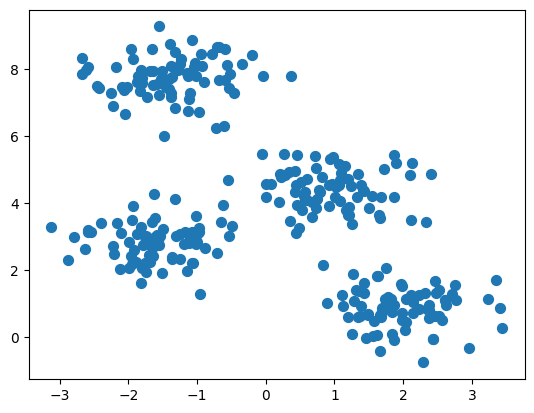

In [ ]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Complete the function kmeans_clustering bellow, and use it for clustering the data with speficied number of clusters.

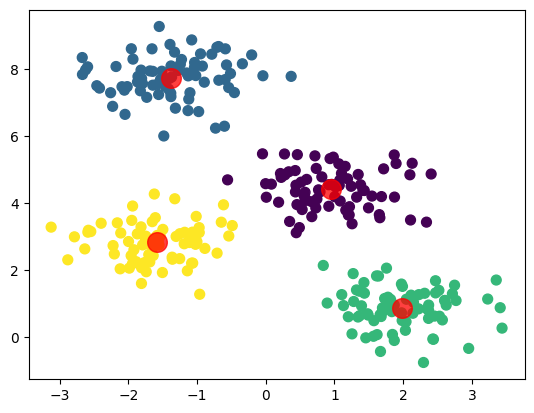

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def kmeans_clustering(X, n_clusters, rseed=2):
    # 1. Randomly initialize cluster centers
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        # complete the function here, you can use pairwise_distances_argmin from sklearn.metrics
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers =  np.array([X[labels == j].mean(0) for j in range(n_clusters)]) # complete the function here

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

centers, labels = kmeans_clustering(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.show()

k-means is limited to linear cluster boundaries
The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach (see the following figure):

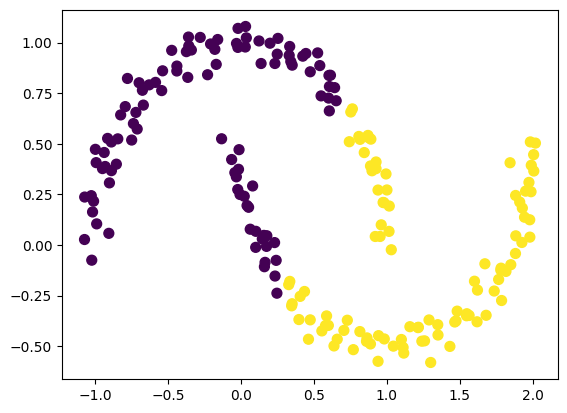

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

centers, labels = kmeans_clustering(X, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Example: K-means for color compression

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn datasets module.


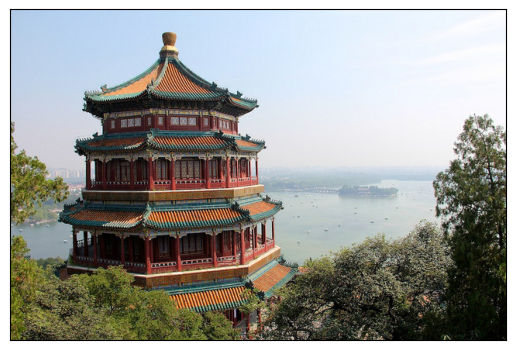

In [ ]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size `(height, width, RGB)`, containing red/blue/green contributions as integers from 0 to 255:

In [ ]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to `[n_samples, n_features]` and rescale the colors so that they lie between 0 and 1:

In [ ]:
data = china / 255.0  # use 0...1 scale
data = data.reshape(-1, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency (see the following figure):

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.default_rng(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

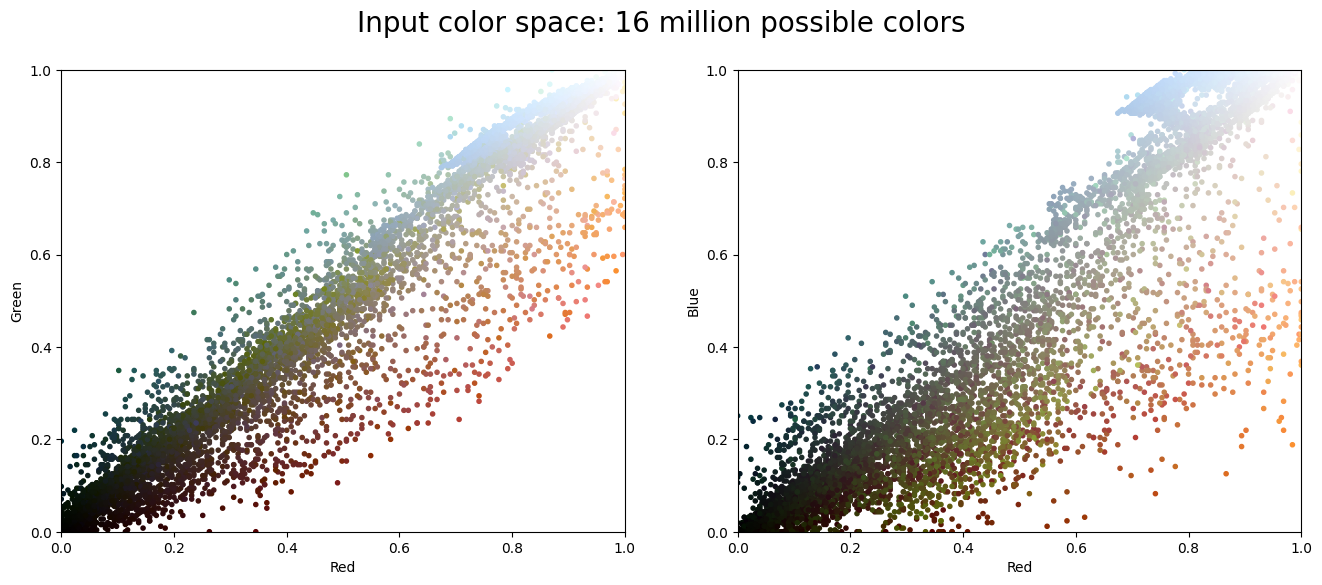

In [ ]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space.

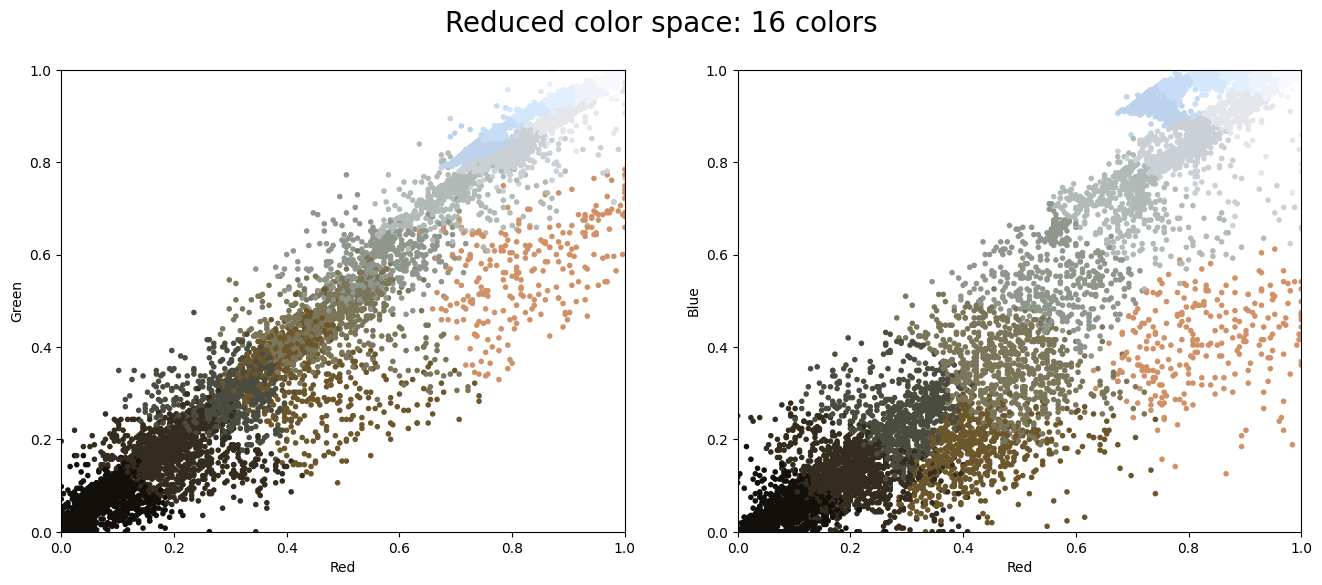

In [ ]:
centers, labels = kmeans_clustering(data, 16)
new_colors = np.vstack([centers[l] for l in labels])
plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a recoloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this (see the following figure):

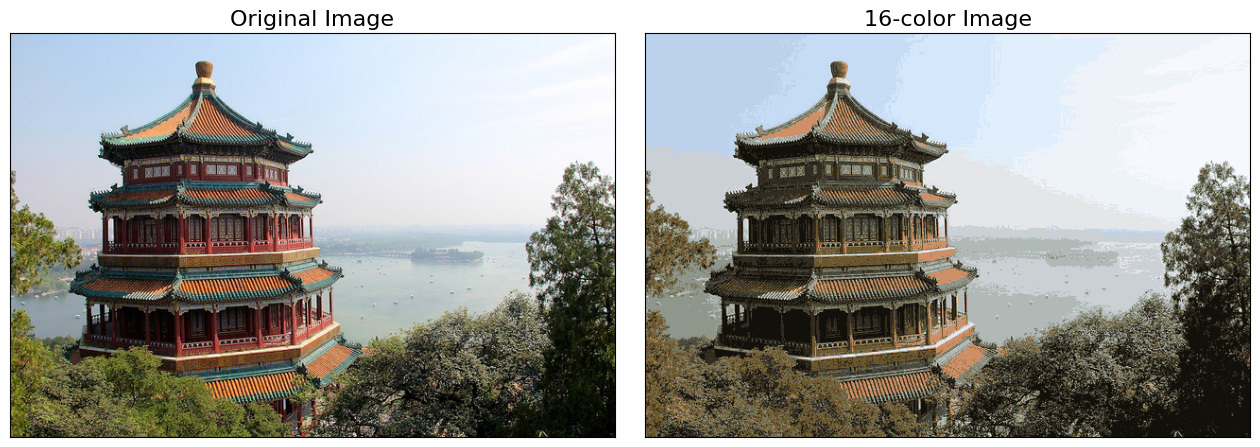

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
In terms of the bytes required to store the raw data, the image on the right achieves a compression factor of around 1 million!
Now, this kind of approach is not going to match the fidelity of purpose-built image compression schemes like JPEG, but the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.

## Part II: Kernel K-means (Spectral Clustering)

One version of kernel k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm (see the following figure):

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


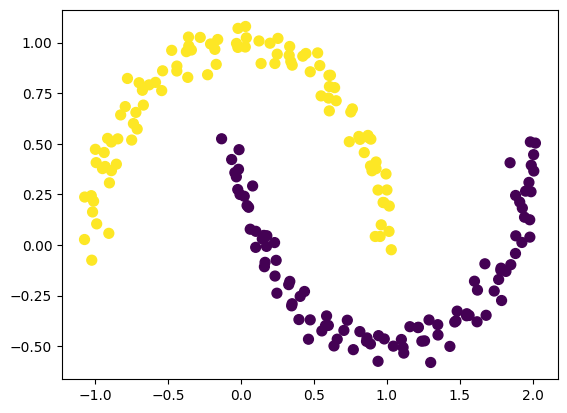

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');